## Raster Data

#### GDAL

Geospatial Data Abstraction Library http://www.gdal.org

Supports more than 100 **Raster Formats**

#### Rasterio

Uses GDAL and has a Pythonic interface

https://github.com/mapbox/rasterio  <br/>
https://rasterio.readthedocs.io/en/stable/


Download example rasterdata

### What is a Worldfile ?

Georeferencing Raster Data using "World files".<br/>
The specification was introduced by Esri.

* TIFF -> .tfw  
* PNG -> .pgw 
* JPEG -> .jgw  
* GIF   -> .gfw

**ASCII Text file associated with the image**

* Line 1: A: pixel size in the x-direction in map units/pixel
* Line 2: D: rotation about y-axis  (-> most cases 0)
* Line 3: B: rotation about x-axis  (-> most cases 0)
* Line 4: E: pixel size in the y-direction in map units, almost always negative
* Line 5: C: x-coordinate of the center of the upper left pixel
* Line 6: F: y-coordinate of the center of the upper left pixel



In [2]:
import geoutils

In [3]:
path = "http://data.geopython.xyz/bluemarble/"
world = "world.tif"
worldfile = "world.tfw"

In [5]:
geoutils.download(path+world, "geodata/world.tif")
geoutils.download(path+worldfile, "geodata/world.tfw")

100% done 	[****************************************************************************************************]
100% done 	[****************************************************************************************************]


## 1. Using GDAL (Python Binding)

In [6]:
from osgeo import gdal
from osgeo.gdalconst import *
import numpy as np

In [7]:
dataset = gdal.Open("geodata/world.tif")
if dataset is None:
    raise IOError("can't open dataset!")

In [8]:
geotransform = dataset.GetGeoTransform()

In [9]:
print(geotransform)

(-180.0, 0.17578125, 0.0, 90.0, 0.0, -0.17578125)


In [10]:
width = dataset.RasterXSize
height = dataset.RasterYSize
print(width, height)

2048 1024


#### Worldfile

* Image Size is ist 2048 x 1024
* Extent is (-180, -90) to (+180, +90)


* Line 1: Pixel size in x direction: 360/2048 
* Line 2: 0 (no Rotation)
* Line 3: 0 (no Rotation)
* Line 4: Pixel size in y direction: -180/1024 
* Line 5: x-coordinate of the **center** UL Pixel
* Line 6: y-coordinate of the **center** UL Pixel


Difference between Geotransform and World-File?

In [11]:
!cat geodata/world.tfw

'cat' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [12]:
nbytes = 3*dataset.RasterXSize*dataset.RasterYSize
print("memory required:", nbytes, "Bytes")
print("memory required:", nbytes/1024, "KB")
print("memory required:", nbytes/1024/1024, "MB")
print("memory required:", nbytes/1024/1024/1024, "GB")

memory required: 6291456 Bytes
memory required: 6144.0 KB
memory required: 6.0 MB
memory required: 0.005859375 GB


In [13]:
# Close the file:
dataset = None

Let's convert our file using the gdal programs (https://gdal.org/programs/index.html)

gdal_translate -of GTiff -a_srs EPSG:4326 input_file.tif output_file.tif -outsize 2048 1024 

open a terminal and enter:

`gdal_translate -of GTiff -a_srs EPSG:4326 geodata/world.tif geodata/bluemarble.tif`


In [14]:
dataset = gdal.Open("geodata/world.tif")
if dataset is None:
    print("error")

In [15]:
def pixelToMap(gt, pos):
    return (gt[0] + pos[0] * gt[1] + pos[1] * gt[2],
            gt[3] + pos[0] * gt[4] + pos[1] * gt[5])

In [16]:
pixelToMap(geotransform, (0,0))

(-180.0, 90.0)

In [17]:
pixelToMap(geotransform, (2049,1024))

(180.17578125, -90.0)

In [18]:
def mapToPixel(gt, pos): 
    return (int((pos[0] - gt[0]) / gt[1]), 
            int((pos[1] - gt[3]) / gt[5]))

In [19]:
mapToPixel(geotransform, (7.6380743, 47.5343704))

(1067, 241)

### Reading Data

In [20]:
bands = dataset.RasterCount   # number of "channels", for example red+green+blue = 3
print(bands)

3


In [21]:
redband = dataset.GetRasterBand(1)
greenband = dataset.GetRasterBand(2)
blueband = dataset.GetRasterBand(3)

In [22]:
redband.DataType

1

In [23]:
gdal.GDT_Byte
gdal.GDT_UInt16
gdal.GDT_UInt32
gdal.GDT_Int16
gdal.GDT_Int32
gdal.GDT_Float32
gdal.GDT_Float64

print("typical C..")

typical C..


In [24]:
if redband.DataType == gdal.GDT_Byte:
    print("band is of datatype byte")

band is of datatype byte


In [25]:
r = redband.ReadAsArray()   # Optional parameters: (xoff, yoff, xsize, ysize, bufx, bufy)

In [26]:
print(r)

[[ 10  10  10 ...  10  10  10]
 [ 10  10  10 ...  10  10  10]
 [ 10  10  10 ...  10  10  10]
 ...
 [213 219 219 ... 218 220 206]
 [213 219 219 ... 218 220 206]
 [206 211 210 ... 210 212 199]]


In [27]:
print(type(r))
print(r.dtype)

<class 'numpy.ndarray'>
uint8


In [28]:
g = greenband.ReadAsArray()
b = blueband.ReadAsArray()

#### Let's display our image

In [29]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np

In [30]:
rgb = np.dstack((r,g,b))  # convert to r,g,b tuples

In [31]:
rgb;

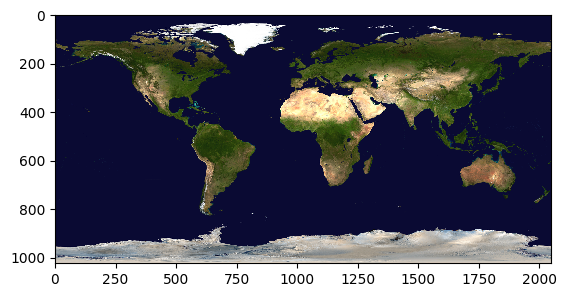

In [32]:
plt.imshow(rgb, interpolation='nearest');

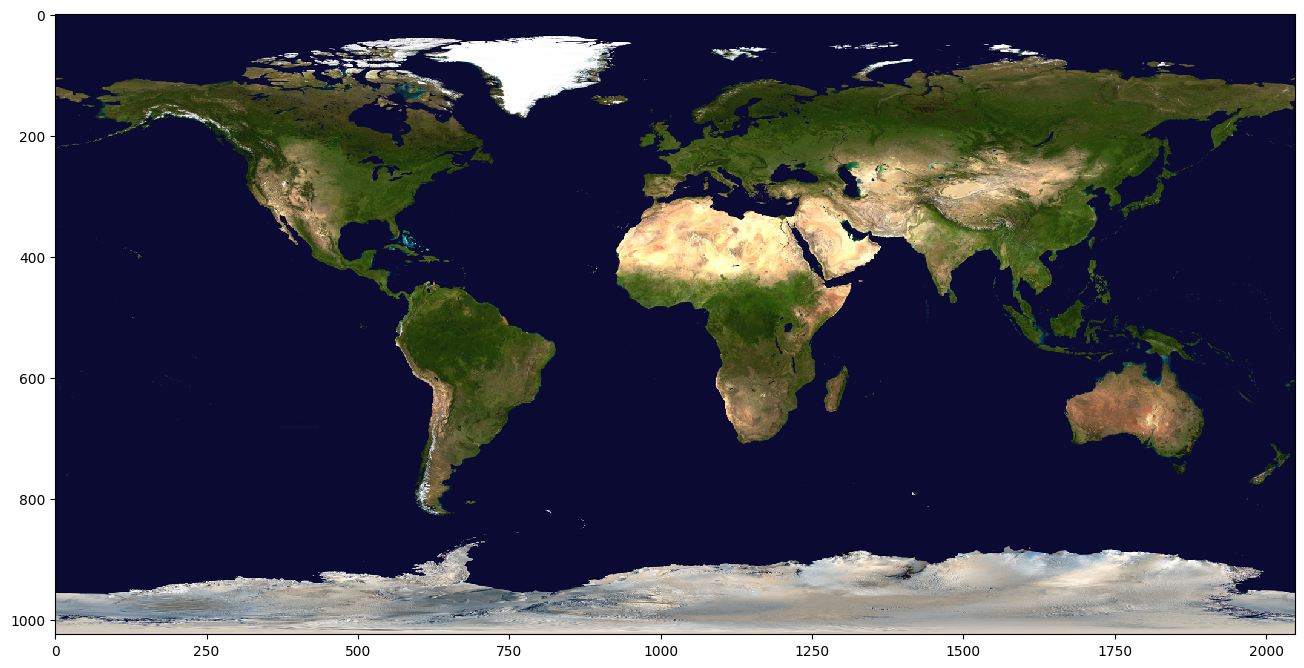

In [33]:
fig = plt.figure(figsize=(16,9))
plt.imshow(rgb, interpolation='nearest');

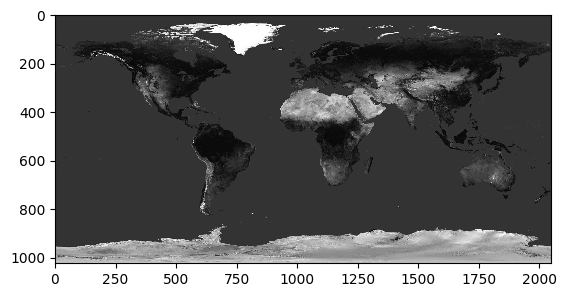

In [34]:
plt.imshow(b, interpolation='nearest', cmap='gray'); # https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

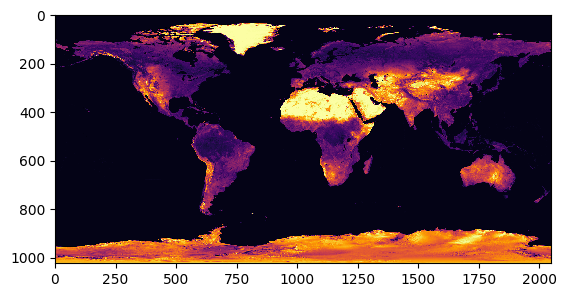

In [35]:
plt.imshow(r, interpolation='nearest', cmap='inferno');

### Windowed Reading

In [36]:
redband = dataset.GetRasterBand(1)
greenband = dataset.GetRasterBand(2)
blueband = dataset.GetRasterBand(3) 

r = redband.ReadAsArray(0,0,512,512)   
g = greenband.ReadAsArray(0,0,512,512) 
b = blueband.ReadAsArray(0,0,512,512) 

In [37]:
rgb = np.dstack((r,g,b))

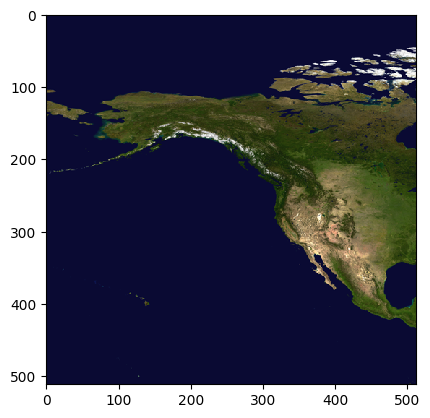

In [38]:
plt.imshow(rgb, interpolation='nearest');

Interpolations:
    
https://matplotlib.org/3.3.1/gallery/images_contours_and_fields/interpolation_methods.html

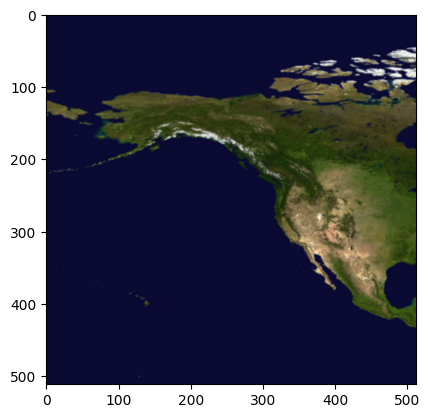

In [39]:
plt.imshow(rgb, interpolation='bicubic');

In [40]:
dataset = gdal.Open("/data/geo/BlueMarble/bluemarble_july_86400x43200.tif")
if dataset is None:
    raise IOError("error")

OSError: error

In [41]:
redband = dataset.GetRasterBand(1)
greenband = dataset.GetRasterBand(2)
blueband = dataset.GetRasterBand(3) 

width = dataset.RasterXSize
height = dataset.RasterYSize
print(width, height)

AttributeError: 'NoneType' object has no attribute 'GetRasterBand'

In [ ]:
print(3*width*height / 1024 / 1024, "MB")

In [ ]:
print(3*width*height / 1024 / 1024 / 1024, "GB")

In [ ]:
%%timeit -n1 -r1
r = redband.ReadAsArray(0,0,86400, 43200, 2048, 1024)    # Optional parameters: (xoff, yoff, xsize, ysize, bufx, bufy)
g = greenband.ReadAsArray(0,0,86400, 43200, 2048, 1024) 
b = blueband.ReadAsArray(0,0,86400, 43200, 2048, 1024) 

#### This is quite fast!

Let's display it, this can't be??

In [ ]:
rgb = np.dstack((r,g,b))

In [ ]:
f = plt.figure(figsize=(4, 3))
plt.imshow(rgb);

### Reason: Overviews

In [ ]:
print(redband.GetOverviewCount())
print(greenband.GetOverviewCount())
print(blueband.GetOverviewCount())

In [ ]:
width/2, height/2

In [ ]:
width/4, height/4

In [ ]:
width/8, height/8

In [ ]:
width/16, height/16

In [ ]:
dataset = None  # free all memory

### Windowed Reading for processing large datasets

For the following examples we're using our small dataset for this, or we run out of memory, because we'll do some stupid things...

In [ ]:
dataset = gdal.Open("geodata/world.tif")
if dataset is None:
    print("error")

lets get the min and max read pixel in the dataset

In [ ]:
redband = dataset.GetRasterBand(1)
greenband = dataset.GetRasterBand(2)
blueband = dataset.GetRasterBand(3) 

width = dataset.RasterXSize
height = dataset.RasterYSize

In [ ]:
!ls geodata/world.tif -lah

#### Pixelwise reading - don't do that ever!

In [ ]:
%%timeit -n1 -r1

maxred_total = 0

for i in range(height):
    for j in range(width):
        r = redband.ReadAsArray(j,i,1,1)    # every pixel...
        g = greenband.ReadAsArray(j,i,1,1)
        b = blueband.ReadAsArray(j,i,1,1)
    
        # and now calc the max red pixel:
    
        maxred_pixel = r[0][0] # current read value
        maxred_total = max(maxred_total, maxred_pixel)

In [ ]:
!gdalinfo geodata/world.tif 

#### Blockwise reading - the way to go!


In [ ]:
%%timeit -n1 -r1

maxred_total = 0

xBSize = 128
yBSize = 128    

# it is also possible to get the blocksize by calling: redband.GetBlockSize() 
# but this is not always reliable...


for i in range(0, height, yBSize):
    if i + yBSize < height:
        numRows = yBSize
    else:
        numRows = height - i
    
    for j in range(0, width, xBSize):
        if j + xBSize < width:
            numCols = xBSize
        else:
            numCols = width - j
            
        r = redband.ReadAsArray(j,i,numCols,numRows)
        g = greenband.ReadAsArray(j,i,numCols,numRows)
        b = blueband.ReadAsArray(j,i,numCols,numRows)
        
        maxred_block = np.max(r) # max from block
        maxred_total = max(maxred_total, maxred_block)

## Using Rasterio (Pythonic Interface to GDAL)

In [ ]:
import rasterio

### Opening a Raster Data Set

In [ ]:
dataset = rasterio.open('geodata/world.tif')

In [ ]:
dataset.name

In [ ]:
dataset.mode

In [ ]:
dataset.count

In [ ]:
dataset.indexes

In [ ]:
dataset.width

In [ ]:
dataset.height

In [ ]:
dataset.crs

In [ ]:
dataset.transform 

In [ ]:
~dataset.transform

In [ ]:
dataset.bounds

In [ ]:
print(dataset.bounds.left)
print(dataset.bounds.bottom)
print(dataset.bounds.right)
print(dataset.bounds.top)

In [ ]:
dataset.transform * (0, 0)  # Transformation Pixel(0,0)

In [ ]:
~dataset.transform * (0, 0) # Inverse Transformation WGS84(0,0)

In [ ]:
~dataset.transform * (8.539434, 47.378109)

In [ ]:
px,py = ~dataset.transform * (8.539434, 47.378109)
print(px,py)

### Reading Data

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
dataset = rasterio.open("geodata/world.tif", 'r')

r = dataset.read(1)
g = dataset.read(2)
b = dataset.read(3)

# scaled:
#r = dataset.read(1, out_shape=(100,200))
#g = dataset.read(2, out_shape=(100,200))
#b = dataset.read(3, out_shape=(100,200))

In [ ]:
rgb = np.dstack((r,g,b))  # create (r,g,b) tuples for each pixel

In [ ]:
fig, ax = plt.subplots(figsize=(15,9))
ax.imshow(rgb, interpolation='nearest')
ax.plot(px,py, 'ro');

### Windowed read in rasterio

In [ ]:
import rasterio 

dataset = rasterio.open('geodata/world.tif')

In [ ]:
w = ((256,512),(1024,1280))

r = dataset.read(1, window=w)
g = dataset.read(2, window=w)
b = dataset.read(3, window=w)

In [ ]:
rgb = np.dstack((r,g,b))

In [ ]:
fig, ax = plt.subplots(figsize=(15,9))
ax.imshow(rgb, interpolation='nearest');